In [1]:
shared_cts = ['L6_IT_CTX_Glut',
 'CA1-ProS_Glut',
 'STR-PAL_Chst9_Gaba',
 'Pvalb_Gaba',
 'L23_IT_ENT_Glut',
 'OPC_NN',
 'L23_IT_CTX_Glut',
 'L5_ET_CTX_Glut',
 'L23_IT_PPP_Glut',
 'Lamp5_Gaba',
 'CA3_Glut',
 'Sst_Gaba',
 'LA-BLA-BMA-PA_Glut',
 'SUB-ProS_Glut',
 'Microglia_NN',
 'Astro-NT_NN',
 'Oligo_NN',
 'L6_CT_CTX_Glut',
 'L5_NP_CTX_Glut',
 'Vip_Gaba',
 'STR_D1_Sema5a_Gaba',
 'Astro-TE_NN',
 'DG_Glut',
 'VLMC_NN',
 'L6bCT_ENT_Glut',
 ] #'STR_D1_Gaba'

In [2]:
def get_luisa_deg(ct):
    deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
    expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
    use_genes = expr[expr.sum(axis = 1) > 0.1].index
    stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)
    
    luisa_deg = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
    luisa_deg['log2(18mo/2mo)'] = np.log2(luisa_deg['fc']) 
    luisa_deg['-log10(padj)'] = -np.log10(luisa_deg['fdr'] + _min)
    luisa_deg =luisa_deg[luisa_deg['fdr'] < 0.5]
    return luisa_deg

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
_min = 2e-200

In [5]:
all_diff_domain = pd.read_csv('ALL.Diff.Domain.csv', index_col = 0)
all_diff_domain = all_diff_domain[all_diff_domain['celltype'].isin(shared_cts)]

In [6]:
all_diff_domain = all_diff_domain[all_diff_domain['8wk'] < 0.2]

In [7]:
example_cts = all_diff_domain['celltype'].value_counts().index[:6]
example_cts

Index(['DG_Glut', 'CA1-ProS_Glut', 'L23_IT_CTX_Glut', 'CA3_Glut',
       'Astro-TE_NN', 'L6_CT_CTX_Glut'],
      dtype='object', name='celltype')

In [8]:
example_cts = ['DG_Glut', 'CA1-ProS_Glut', 'CA3_Glut','L23_IT_CTX_Glut', 'L6_IT_CTX_Glut','L6_CT_CTX_Glut'] #'Astro-TE_NN', 

In [9]:
luisa_dir = '/home/qzeng_salk_edu/project/2404017_check_rna/luisa_deg'

In [10]:
def get_shared_df(ct):
    gene_meta_path = '/data/metadata/gencode.vM22.basic.annotation.gene.flat.tsv.gz'
    mouse_genes = pd.read_csv(gene_meta_path,sep="\t")[['chrom', 'start', 'end', 'gene_id','gene_name']]
    
    # get my result
    deg_dir = f'/data/female-amb/Diff.Result/DEG.stats/{ct}'
    expr = pd.read_hdf(f'{deg_dir}/expr.hdf').T
    
    #select highly expressed genes
    use_genes = expr[expr.sum(axis = 1) > 0.05].index
    use_genes = expr.index
    stats = np.load(f"{deg_dir}/{ct}.2mo-{ct}.18mo.npz") #fc:(2mo/18mo)

    result = pd.DataFrame({'fc': (expr[f'{ct}.18mo'] /expr[f'{ct}.2mo']).values,'fdr':stats['fdr']}, index = expr.index).loc[use_genes]
    result['log2(18mo/2mo)'] = np.log2(result['fc'])
    result['-log10(padj)'] = -np.log10(result['fdr'] + _min)
    result = pd.concat([result, expr], axis = 1).dropna()

    # luisa result
    luisa_df = pd.read_csv(f'{luisa_dir}/{ct}.csv', index_col = 0)
    luisa_df['-log10(padj)'] = -np.log10(luisa_df['p_val_adj'] + 1e-200)

    shared_df = pd.concat([result[['log2(18mo/2mo)','fdr','-log10(padj)']], luisa_df[['avg_log2FC','p_val_adj']]], axis= 1).dropna()
    shared_df = shared_df[(abs(shared_df['log2(18mo/2mo)']) > 0.1) & (shared_df['fdr'] < 0.05) & (shared_df['p_val_adj'] < 0.05)] #
    return shared_df

In [15]:
ct = 'DG_Glut'
all_genes = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
all_genes['-log10(padj)'] = -np.log10(all_genes['p_val_adj']+ _min)
all_genes['log2(18mo/2mo)'] = -all_genes['avg_log2FC']

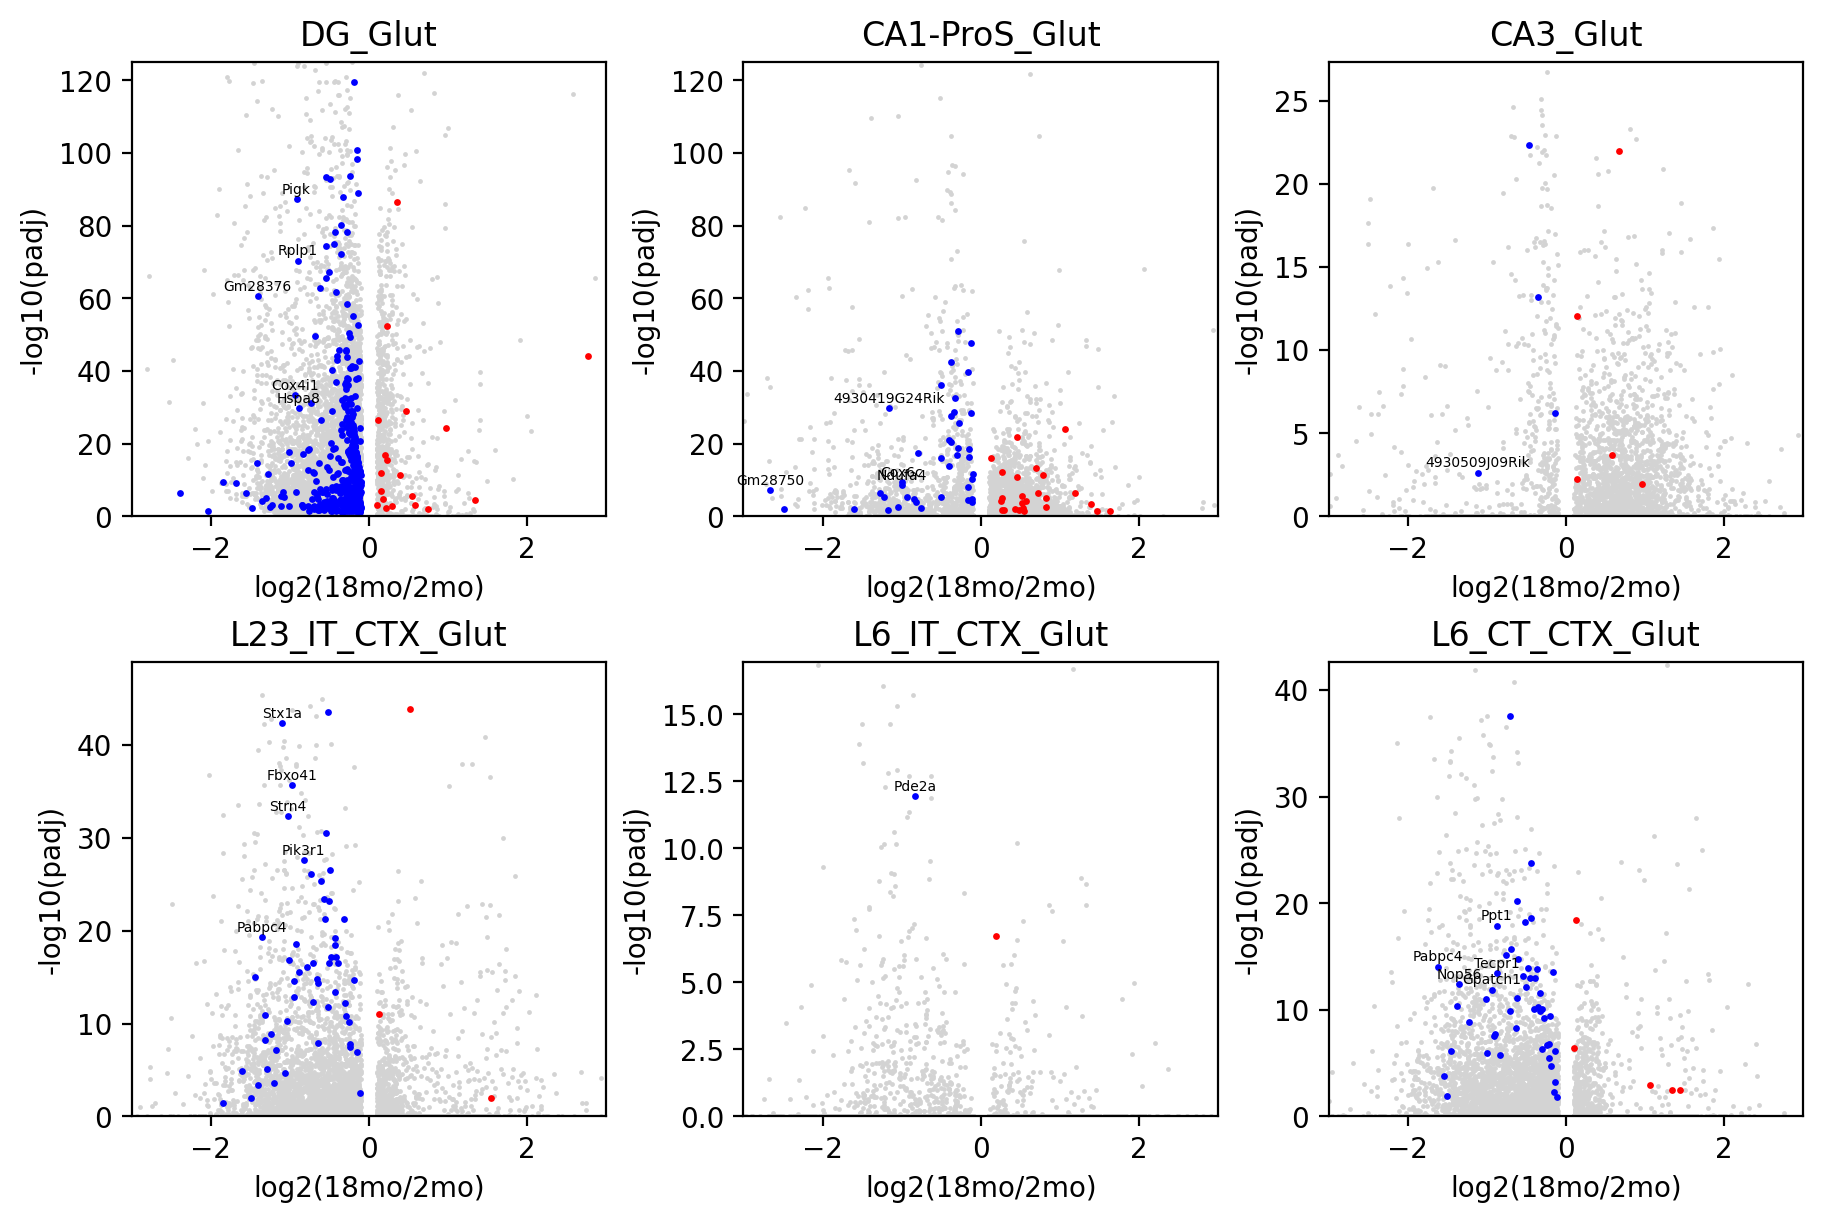

In [11]:
ncols = 3
nrows = 2

fig, axes = plt.subplots(figsize = (ncols*3,nrows*3), 
                         ncols = ncols, nrows = nrows, 
                         dpi = 200, constrained_layout = True)
for ct, ax in zip(example_cts,axes.ravel()):
    ## this is result for all genes
    all_genes = pd.read_csv(f"{luisa_dir}/{ct}.csv", index_col = 0)
    all_genes['-log10(padj)'] = -np.log10(all_genes['p_val_adj']+ _min)
    all_genes['log2(18mo/2mo)'] = -all_genes['avg_log2FC']
    #all_genes = all_genes[all_genes['p_val_adj'] < 0.05]
    # all_genes = get_all_gene(ct)
    ## get all domain genes
    all_overlap = pd.read_csv(f'New.Domain.Genes.Expression/{ct}/All.Overlap.Domain.Genes.csv', index_col ='gene_name')

    ## select those deg domain genes
    shared_deg_df = get_shared_df(ct)
    shared_deg_df = shared_deg_df[shared_deg_df.index.isin(all_overlap.index)]

    sns.scatterplot(data = all_genes,
                    linewidth = 0,
                    ax = ax,
                    color = 'lightgrey',
                    s = 3,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

    sns.scatterplot(data = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] < 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'blue',
                    s = 6,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')

    sns.scatterplot(data = shared_deg_df[shared_deg_df['log2(18mo/2mo)'] > 0],
                    linewidth = 0,
                    ax = ax,
                    color = 'red',
                    s = 6,
                    x = 'log2(18mo/2mo)',
                    y = '-log10(padj)')
    ax.set_title(ct)
    ylim = shared_deg_df['-log10(padj)'].max() + 5
    if ylim > 200:
        ylim = 125
    ax.set(xlim = (-3,3), ylim = (0,ylim) ) #
    
    top_genes = shared_deg_df[(shared_deg_df['log2(18mo/2mo)'] < -0.8)]
    top_genes = top_genes.sort_values('-log10(padj)',ascending = False).head(5)
    for _, row in top_genes.iterrows():
        ax.annotate(row.name, (row['log2(18mo/2mo)'], row['-log10(padj)']), 
                    textcoords="offset points", xytext=(0,2), ha='center', fontsize = 5)